# 2. Graphical monitoring and overfitting

## Regression example: California Housing

Let us consider next how a *regression* problem (i.e. predicting the value of a continuously varying numerical target variable) can be analyzed with a neural network model. After some initial imports, we begin by downloading a dataset concerning housing prizes in California; see [this link](https://keras.io/api/datasets/california_housing/) for more details.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Input, Dense
from keras.datasets import california_housing

(inputs, targets), (x_test, y_test) = california_housing.load_data(version='small', 
                                        test_split=0.2)
print(inputs.shape, targets.shape)
print(x_test.shape, y_test.shape)

(480, 8) (480,)
(120, 8) (120,)


The small version of the dataset consists of 600 samples with 8 numerical input features, and the numerical target variable. Part of the labeled data (20%, or 120 samples in this example) is reserved for final testing of the model after the training has been completed. However, this time we divide the remaining 480 data samples further in two separate sets: a training set containing 380 samples, and **a validation set** of 100 samples. Having a validation set (sometimes also called *development set*) serves two useful purposes:

1. **Monitoring during training**: when the model is trained, and the selected metrics recorded after each training epoch for both sets, a separate validation set provides information about the model's performance with data not used for actual training. Not only does this provide more reliable estimate for the performance, but also makes it possible to recognize overfitting, when it happens.

2. **Hyperparameter optimization**: when solving a machine learning problem with neural networks, it is usually necessary to try several models with different architectures and different values for hyperparameters (the number of hidden layers, and the numbers of neurons in each hidden layer). The performance metrics of each different model can be calculated with the validation set, and the best one chosen as the final model; this can then be evaluated using the independent test set to obtain a very reliable performance estimate.  

In [2]:
# Extract sets for training and validation
x_train = inputs[:380]
y_train = targets[:380]
x_val = inputs[380:]
y_val = targets[380:]

Next, we standardize the input features by subtracting the mean and dividing by the standard deviation. Note that only the training set is used to estimate the mean and standard deviation in the dataset; both the validation set and the test set are then also standardized using these values. In addition, we divide the target variable (house prize in dollars) by 100000, in order to obtain values on the order of unity.

In [3]:
mean = x_train.mean(axis=0) # mean and standard deviation computed from training set only
std = x_train.std(axis=0)
x_train -= mean
x_train /= std
x_test -= mean
x_test /= std
x_val -= mean
x_val /= std
y_train /= 1e5
y_test /= 1e5
y_val /= 1e5

After this simple preprocessing, we are ready to construct a neural network model for treating the regression problem for the above data.

In the cell below, a model with two fully connected hidden layers with ReLU activation is built. Note that the output layer only contains a single unit for outputting the prediction for the prize, and no activation function is used (the model is able to output any value without restrictions). The appropriate loss function for a regression problem is mean squared error (MSE), and the mean absolute error (MAE) is chosen as the metric to be monitored.

In [4]:
# define the model architecture
model = Sequential([
    Input(shape=(8,)),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)
    ])

# configure the learning algorithm
model.compile(optimizer='adam',loss='mse',metrics=['mae'])

Next, we train the model for 500 epochs, with the validation set extracted above. The zero value for the verbose parameter suppresses the outputs during training; because of the large number of epochs, the printouts would overwhelm the screen. Instead, we save the information about training progress to a variable `history`, referring to a History object returned by the fit method.

In [5]:
history = model.fit(x_train, y_train, epochs=500, batch_size=32, validation_data=(x_val, y_val), verbose=0)

The stored object contains a dictionary `history`, whose keys can be used to access arrays containing the recorded metrics after each epoch. Using Matplotlib, we can e.g. take a look at loss values during training both for the training set and validation set as follows (note that first ten epochs are discarded for clearer visualization, since these values are much larger than the rest): 

Text(0, 0.5, 'Loss')

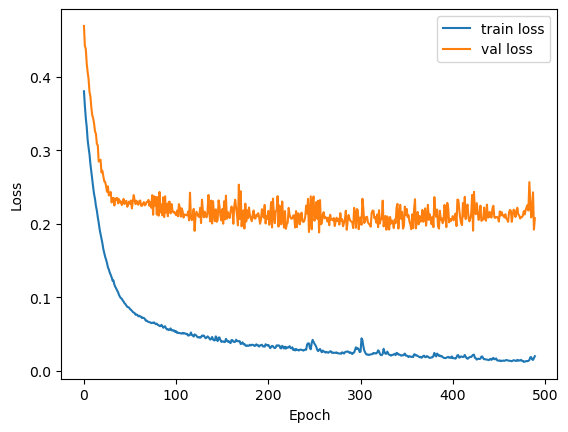

In [6]:
plt.plot(history.history['loss'][10:], label='train loss')
plt.plot(history.history['val_loss'][10:], label='val loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

Note that while the training loss decreases throughout, the validation loss only decreases during the first approx. 100 epochs, after which the validation loss stalls, and even increases slightly. This is indicative of overfitting: while the ability of the model to predict training samples correctly improves, the ability to predict previously unseen samples does not. The learning then begins to concentrate on training set details that do not generalize well.

The mean absolute error graphs show similar behaviour:

Text(0, 0.5, 'Mean absolute error (in 100000 $)')

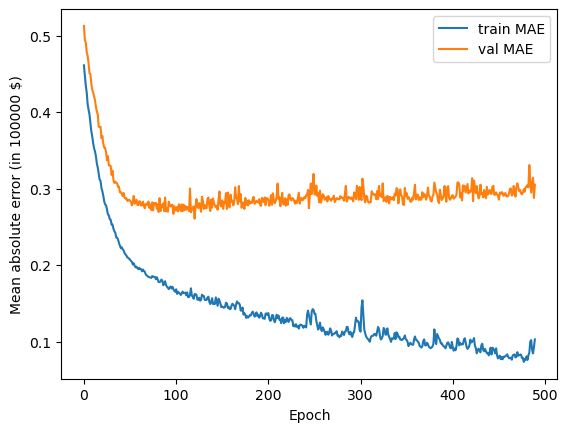

In [7]:
plt.plot(history.history['mae'][10:], label='train MAE')
plt.plot(history.history['val_mae'][10:], label='val MAE')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Mean absolute error (in 100000 $)')

Now that we have recognized overfitting from the graphs above, what can we do about it? One simple alternative is to use **early stopping**: terminate training when the performance metrics for the validation set no longer improve. For this purpose, we build a fresh model, and train it only for 100 epochs. Also, for this final training we use *both the training and validation data combined*; this is the usual practice after the validation set has fulfilled its purpose in obtaining the details of the chosen model. 

In [8]:
x_train_full = np.concatenate((x_train, x_val), axis=0) # join train + val sets
y_train_full = np.concatenate((y_train, y_val), axis=0)

model = Sequential([
    Input(shape=(8,)),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)
    ])

model.compile(optimizer='adam',loss='mse',metrics=['mae'])
model.fit(x_train_full, y_train_full, epochs=100, batch_size=32, verbose=0)

For final performance test, we evaluate our trained model with the test set:

In [9]:
test_loss, test_mae = model.evaluate(x_test, y_test)
print(f'Test mean absolute error: {test_mae:.4f}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3216 - mae: 0.3110 
Test mean absolute error: 0.3110


It is often a good idea to compare the results of the model with a trivial baseline, such as always predicting the mean value of the targets in the training set:

In [10]:
from keras.losses import MeanAbsoluteError

y_pred_baseline = np.full_like(y_test, np.mean(y_train_full, axis=0))
mae_fn = MeanAbsoluteError()
mae_baseline = mae_fn(y_test, y_pred_baseline).numpy()
print(f'Mean baseline MAE: {mae_baseline:.4f}')

Mean baseline MAE: 0.8367


Evidently, our model is already at least able to beat this baseline. In order to further improve the model, you could proceed either by

* **optimizing hyperparameters**: trying out various model architectures having different neuron numbers in hidden layers, or different number of layers,

or 

* **implementing regularization**: modifying the model and/or learning algorithm to help the model to generalize better, and fight the effects of overfitting.

Below we review the most commonly used regularization techniques. However, let us first take a brief look at some important loss functions in machine learning. 

## Loss functions

Loss functions quantify the difference between the predictions computed by the model and the true target values in the labeled dataset; the training aims to iteratively find the values for the trainable parameters of the model so that this function is minimized. The specific functions used for this purpose depend on the type of the machine learning problem under investigation. Let us next review the most commonly used ones for each problem.

1. **Regression problems: Mean squared error (MSE)**

Consider a batch with $N$ samples labeled with an index $i = 1, ..., N$. If the predictions computed by the regression model for these samples are denoted by $y_{i}$, and the true target values as $t_{i}$, the mean squared error of the batch is

$$
L_{MSE} = \frac{1}{N} \sum_{i=1}^{N} \left( y_{i} - t_{i} \right)^{2}
$$ 
For a regression problem, the output is unrestricted, and there should usually be no activation function for the output layer. 

2. **Binary classification problems: Binary cross entropy**

In binary classification problems, each sample in the batch belongs to one of two alternative classes, labeled as either 0 or 1. Accordingly, $t_{i} = 0$ or $t_{i} = 1$ for each $i = 1, ..., N$. The predictions $y_{i}$ are floating-point numbers in the range between 0 and 1, and are to be interpreted as indicating the probability for the sample to belong to class 1; the correct output form is guaranteed by choosing sigmoid as the activation function for the single unit in the output layer. In this case, the most commonly used loss function is the binary cross entropy defined as

$$
L_{BCE} = -\frac{1}{N} \sum_{i=1}^{N} \left[ t_{i} \log y_{i} +  (1-t_{i}) \log (1-y_{i}) \right]
$$
This function is also sometimes referred to as the *negative log likelihood*, and it quantifies the difference between two probability distributions. Note that depending on the value of $t_{i}$ for a sample, one of the two terms in the above sum always vanishes. 

2. **Multiclass classification problems: Categorical cross entropy**

If the number $K$ of distinct classes in a classification problem is larger than two, the target output is a vector containing $K$ elements, each denoting the probability for the sample to belong to that particular class. For example, for $K = 5$ classes, a sample belonging to class 2 would have the one-hot encoded target label ${\bf t} = (0, 1, 0, 0, 0)$. The output layer of the model should consist of $K$ units; here softmax activation function should be used to guarantee that the outputs are restricted to the proper range 0 ... 1, and have a total sum of 1. 

The appropriate loss function in this case is the categorical cross entropy

$$
L_{CCE} = -\frac{1}{N} \sum_{i=1}^{N} \sum_{j=1}^{K}  t_{ij} \log y_{ij} 
$$
Note that there are now two distinct summations: one over the samples in the batch (denoted by index $i$), and another over the various classes (index $j$). In the expression, $y_{ij}$ denotes the predicted output probability for a sample $i$ to belong to class $j$; the true values $t_{ij}$ are zero except for a single $j$ corresponding to the true label for sample $i$, which has the value 1. If $K = 2$ (binary classification), this definition reduces to binary cross entropy introduced above.

Each of these three functions are directly available in Keras: just pick the appropriate one depending on the problem type, and specify the choice when compiling the model.

## Regularization: fighting overfitting

In the example above, we discussed how early stopping (i.e., terminating training when validation metrics stop improving) can be used to reduce the effects of overfitting. However, there are other alternative techniques to choose from in this respect; these are collectively referred to as **regularization methods**. Let us review a few common ones.

1. **L2 regularization**

This technique is based on the observation that when overfitting occurs, the trainable parameters (weights and biases) of the model often acquire values that vary on a large scale. This can be remedied by modifying the loss function in a suitable manner. In L2 regularization, an additional penalty term is added to the loss function: this term consists of a sum of the squared weights, multiplied by a (usually small) constant. Such a term discourages the model to learn weight values varying over a wide range, and hence provides help against overfitting. 

L2 regularization can be easily implemented for individual Dense layers in a Keras model; see an example in the cell below (the multiplicative constant is given as a parameter):


In [11]:
from keras.regularizers import l2

model = Sequential([
    Input(shape=(8,)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(1)
])

2. **Dropout**

When overfitting occurs, it often relies on fine-tuning the weight values of specific neurons in the network. This tendency can be fought against in a surprising manner: disabling (that is, replacing with zeroes) a certain percentage of randomly chosen neuron outputs in selected layers. Such a procedure forces the model to train to recognize more robust features, which helps with overfitting.

Dropout is implemented with special Dropout layers added in the model; these should be placed *after* the layer whose outputs are to be randomly deactivated. The ratio of dropped units is given as a parameter to the layer:   

In [12]:
from keras.layers import Dropout

model = Sequential([
    Input(shape=(8,)),
    Dense(64, activation='relu'),
    Dropout(0.2), # drop 20% of the outputs
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

3. **Batch normalization**

*Batch normalization* can be used to normalize the outputs of specific layers in the model. This can sometimes stabilize the training and speed it up. The technique consists of two phases: first, all the features are standardized individually (using the means and standard deviations computed over the samples in the batch) to have mean zero and standard deviation 1. Second, the values are scaled and shifted so as not to undermine the ability of the model to learn complex relationships (the values for the parameters needed for scaling and shifting are treated as additional trainable parameters). 

Again, this technique is very easy to implement, as it is directly available as another Keras layer: 

In [13]:
from keras.layers import BatchNormalization

model = Sequential([
    Input(shape=(8,)),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(1)
])

4. **Early stopping**

Finally, we return briefly to the already discussed issue of early stopping. Instead of setting the suitable termination point by hand, it is possible to use one of the available Keras callbacks to terminate training automatically:

In [14]:
from keras.callbacks import EarlyStopping

model = Sequential([
    Input(shape=(8,)),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)
    ])

model.compile(optimizer='adam',loss='mse',metrics=['mae'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model.fit(x_train_full, y_train_full, epochs=500, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 3.7018 - mae: 1.6537 - val_loss: 2.1412 - val_mae: 1.1728
Epoch 2/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8596 - mae: 1.0752 - val_loss: 0.9722 - val_mae: 0.7610
Epoch 3/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1976 - mae: 0.8458 - val_loss: 0.7366 - val_mae: 0.6944
Epoch 4/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8534 - mae: 0.7086 - val_loss: 0.6131 - val_mae: 0.6364
Epoch 5/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6323 - mae: 0.6152 - val_loss: 0.5491 - val_mae: 0.5924
Epoch 6/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5265 - mae: 0.5576 - val_loss: 0.5000 - val_mae: 0.5542
Epoch 7/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4664 - mae: 0.5221 - val_loss: 0.4727 - val_mae: 0.5320
Epoch 8/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4211 - mae: 0.4941 - val_loss: 0.4547 - val_mae: 0.5142
Epoch 9/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.39

This time the training is seen to terminate automatically, after the validation loss has not improved during 10 epochs.